# Anomaly Detection

### Import libraries

In [229]:
# Data manipulation packages
import pandas as pd
import numpy as np
import re
# Data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns 
import folium

# Important tools for modeling and evaluation.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

### Import data

In [174]:
# import for mac
# Import all the monthly csv dataset
nov_20 = pd.read_csv(r"./202011-divvy-tripdata.csv")
dec_20 = pd.read_csv(r'./202012-divvy-tripdata.csv')
jan_21 = pd.read_csv(r'./202101-divvy-tripdata.csv')
feb_21 = pd.read_csv(r'./202102-divvy-tripdata.csv')
march_21 = pd.read_csv(r'./202103-divvy-tripdata.csv')
april_21 = pd.read_csv(r'./202104-divvy-tripdata.csv')
may_21 = pd.read_csv(r'./202105-divvy-tripdata.csv')
jun_21 = pd.read_csv(r'./202106-divvy-tripdata.csv')
july_21 = pd.read_csv(r'./202107-divvy-tripdata.csv')
aug_21 = pd.read_csv(r'./202108-divvy-tripdata.csv')
sept_21 = pd.read_csv(r'./202109-divvy-tripdata.csv')
oct_21 = pd.read_csv(r'./202110-divvy-tripdata.csv')
nov_21 = pd.read_csv(r'./202111-divvy-tripdata.csv')

# Join all months into a single dataframe
months = [nov_20, dec_20, jan_21, feb_21, march_21, april_21, may_21, jun_21, july_21, aug_21, sept_21, oct_21, nov_21]
df_months = pd.concat(months)


In [176]:
# Get basic information
df_months.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5738812 entries, 0 to 359977
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 613.0+ MB


In [177]:
# Check for duplicates
df_months.duplicated().sum()

0

## Data Processing
- Convert the data type
- Calculate ride duration (end - start time)

In [178]:
# Funtion to preprocess datetime string, adding seconds if missing
def preprocess_datetime(dt_str):
    if pd.isna(dt_str):
        return np.nan
    if len(dt_str) == 16:  # Format is missing seconds (YYYY-MM-DD HH:MM)
        return dt_str + ':00'
    # Add leading zero to single-digit hours
    if len(dt_str) == 15 and re.match(r'\d{4}-\d{2}-\d{2} \d:\d{2}', dt_str):
        return dt_str[:11] + '0' + dt_str[11:] + ':00'
    
    # Add leading zero to single-digit hours with missing seconds
    if len(dt_str) == 14 and re.match(r'\d{4}-\d{2}-\d{2} \d:\d{2}', dt_str):
        return dt_str[:11] + '0' + dt_str[11:] + ':00'
    return dt_str

# Apply the preprocessing function to both columns
df_months['started_at'] = df_months['started_at'].apply(preprocess_datetime)
df_months['ended_at'] = df_months['ended_at'].apply(preprocess_datetime)

# Convert to date time
df_months['started_at'] = pd.to_datetime(df_months['started_at'],format='%Y-%m-%d %H:%M:%S')
df_months['ended_at'] = pd.to_datetime(df_months['ended_at'],format='%Y-%m-%d %H:%M:%S')

df_months.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5738812 entries, 0 to 359977
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 613.0+ MB


## Data Extraction

In [179]:
# start day of week [Mon, Tue]
df_months['day'] = df_months['started_at'].dt.day_name()

# start time, from this we can determine if Morn, Afternoon, Night 
df_months['start_time'] = df_months['started_at'].dt.strftime('%H:%M:%S')
df_months['end_time'] = df_months['ended_at'].dt.strftime('%H:%M:%S') # Time when rides ended 

# Creata a column to assign period based on the time

def day_period(time_str):
    hour = int(time_str.split(':')[0])
    if 0 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

# Apply the function to the 'start_time' column
df_months['time_of_day'] = df_months['start_time'].apply(day_period)

# month
df_months['month'] = df_months['started_at'].dt.strftime("%b-%y")

# Find the ride duration is seconds
df_months['ride_duration'] = (df_months['ended_at']-df_months['started_at']).dt.total_seconds()

# Get basic descriptive stats on the duration
df_months['ride_duration'].describe()

count    5.738812e+06
mean     1.208008e+03
std      1.752267e+04
min     -1.742998e+06
25%      4.090000e+02
50%      7.250000e+02
75%      1.318000e+03
max      3.356649e+06
Name: ride_duration, dtype: float64

In [180]:
# Check for missing values
df_months.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    675769
start_station_id      675876
end_station_name      725658
end_station_id        725735
start_lat                  0
start_lng                  0
end_lat                 5022
end_lng                 5022
member_casual              0
day                        0
start_time                 0
end_time                   0
time_of_day                0
month                      0
ride_duration              0
dtype: int64

In [204]:
df_months.shape

(5738812, 19)

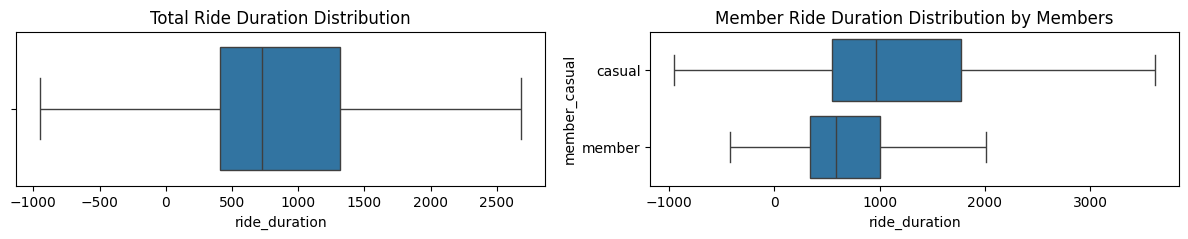

Interquartile range: 909.0
Lower Bound: -954.5
Upper Bound: 2681.5
Mean: 1208.0079748212697


In [182]:
# Get outliers
fig, axes = plt.subplots(1, 2, figsize = (15,2))

# Plot 1
sns.boxplot(ax=axes[0], x=df_months['ride_duration'], showfliers = False)
axes[0].set_title('Total Ride Duration Distribution')

# Plot 2
sns.boxplot(ax=axes[1], x = df_months['ride_duration'], y = df_months['member_casual'], showfliers = False)
axes[1].set_title('Member Ride Duration Distribution by Members')
plt.show()

p25 = df_months['ride_duration'].quantile(0.25) # 25th percentile
p50 = df_months['ride_duration'].quantile(0.5) # 50th percentile
p75 = df_months['ride_duration'].quantile(0.75) # 75th percentile

# Interquartile range
iqr = p75 - p25
print(f'Interquartile range: {iqr}')

# Lower Limit
lower_bound  = p25 - 1.5 * iqr
print(f'Lower Bound: {lower_bound}')

# Upper Limit
upper_bound = p75 + 1.5 * iqr
print(f'Upper Bound: {upper_bound}')

# Mean
print(f'Mean: {df_months['ride_duration'].mean()}')

In [205]:
# Get and store missing values into a dataframe for analysis
df_missing = df_months[df_months.isnull().any(axis=1)].reset_index(drop=True)

# Remove negative ride durations
df_missing = df_missing[df_missing['ride_duration'] >= 0].reset_index(drop=True)

# 
df_missing['missing'] = True

print(f'We have {df_missing.shape[0]} rows with missing values.')
print(f'Which is {100-((df_months.shape[0] - df_missing.shape[0])/df_months.shape[0])*100}% of our dataset.')

We have 990075 rows with missing values.
Which is 17.252264057439078% of our dataset.


In [206]:
# Drop negative ride duration AND keep outliers
df_outliers = df_months[(df_months['ride_duration'] >= 0) & (df_months['ride_duration'] > upper_bound)].reset_index(drop=True)

df_outliers['missing'] = False

df_outliers.shape

(423944, 20)

In [207]:
# Join missing and outliers
df = pd.concat([df_missing, df_outliers], axis=0)

# Check for duplicates
print(f'Number of duplicates {df.duplicated().sum()}.')

# Drop duplicates
df.drop_duplicates(keep='last',inplace=True)

df.head()

Number of duplicates 0.


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day,start_time,end_time,time_of_day,month,ride_duration,missing
0,9E7A79ADA90C2695,electric_bike,2020-11-14 16:04:15,2020-11-14 16:19:33,NaN,NaN,NaN,NaN,41.910000,-87.620000,41.910000,-87.620000,casual,Saturday,16:04:15,16:19:33,Afternoon,Nov-20,918.0,True
1,586E86B0E03B75CE,electric_bike,2020-11-14 09:10:26,2020-11-14 09:23:43,NaN,NaN,Spaulding Ave & Armitage Ave,506.0,41.950000,-87.710000,41.917184,-87.710245,casual,Saturday,09:10:26,09:23:43,Morning,Nov-20,797.0,True
2,953E715FCB27D545,electric_bike,2020-11-14 13:04:38,2020-11-14 13:10:11,NaN,NaN,NaN,NaN,41.790000,-87.590000,41.800000,-87.590000,casual,Saturday,13:04:38,13:10:11,Afternoon,Nov-20,333.0,True
3,C1593A866828113F,electric_bike,2020-11-07 11:48:55,2020-11-07 11:57:46,NaN,NaN,Lake Shore Dr & North Blvd,268.0,41.890000,-87.630000,41.911665,-87.626829,casual,Saturday,11:48:55,11:57:46,Morning,Nov-20,531.0,True
4,0370B5DA8B8E0FA2,electric_bike,2020-11-06 22:23:36,2020-11-06 22:29:15,Morgan St & Polk St,241.0,NaN,NaN,41.872028,-87.650915,41.890000,-87.650000,casual,Friday,22:23:36,22:29:15,Night,Nov-20,339.0,True


## Investigate null rows

### User-Based Analysis
- What is the distribution of outliers across different members?

In [208]:
# Total number of rides
print(f'Total number of bad rides: {df.count()['ride_id']}')

# members and casual
print(f'Members: {df['member_casual'].value_counts()['member']}') 
print(f'Casual: {df['member_casual'].value_counts()['casual']}') 

Total number of bad rides: 1414019
Members: 575433
Casual: 838586


In [209]:
# Ride duration compared to 
df.groupby('member_casual').agg({'ride_duration':'mean'}).reset_index()

,member_casual,ride_duration
0,casual,4383.239080
1,member,1480.111851


### Bike Type-Based Analysis
- Which bike models or types have higher rates of anomalies or outliers?
- Do certain bike types experience more mechanical issues leading to outlier rides?
- How does the distribution of ride durations vary across different bike types?


#### Which bike models or types have higher rates of outliers or bad data?

rideable_type
electric_bike    1089479
classic_bike      213163
docked_bike       111377
Name: count, dtype: int64


Text(0, 0.5, 'Number of Rides')

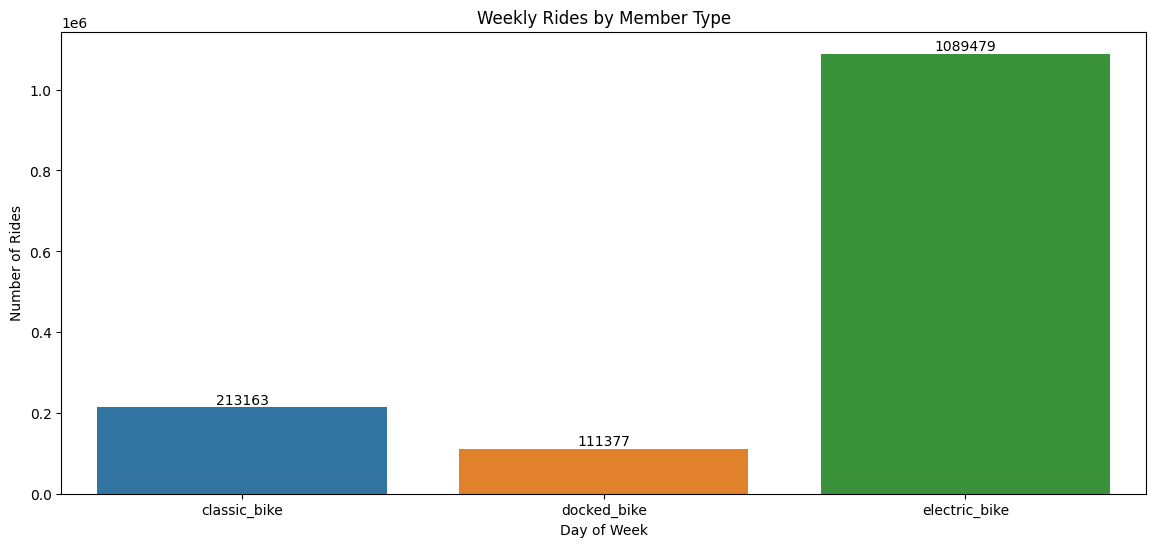

In [210]:
print(df['rideable_type'].value_counts())

df_bp = df.groupby(['rideable_type']).count()['ride_id'].reset_index()

# Plot
plt.figure(figsize = (14,6))
sns.barplot(data = df_bp, x = 'rideable_type', y = 'ride_id', hue = 'rideable_type')

# Plot a bargraph
def addlabels(x,y,labels):
    for i in range(len(x)):
        plt.text(i,y[i],labels[i], ha='center', va='bottom')

addlabels(df_bp.index, df_bp['ride_id'], df_bp['ride_id'])

plt.title('Weekly Rides by Member Type')
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')


#### Do certain bike types experience more mechanical issues leading to outlier rides?
We observe that electric bikes contribute to a significant percentage of missing data or outliers. This can be due to several factors:
- Mechanical Issues: Electric bikes may experience more frequent mechanical problems compared to classic and docked bikes, leading to higher instances of outliers in the data.
- Battery Problems: Electric bikes might experience battery issues that cause them to be underutilized or misreported. Battery failures or inconsistencies in charge levels can result in incomplete or incorrect ride data.
- Different User Behavior: Users might use electric bikes differently, such as for longer trips or more frequent short trips, leading to variations in the data that appear as outliers. This different usage pattern can be attributed to the ease and convenience of electric bikes compared to other types.

#### How does the distribution of ride durations vary across different bike types?

In [211]:
df.groupby('rideable_type').agg({'ride_duration':['median','mean']})

ride_duration              
                     median          mean
rideable_type                            
classic_bike         3955.0   7721.746541
docked_bike          4711.0  12533.569121
electric_bike         757.0   1363.483045

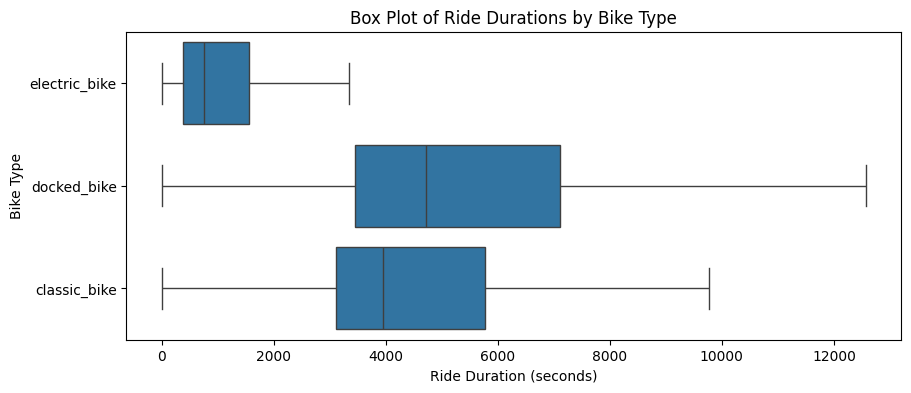

In [212]:
import seaborn as sns

# Plot box plots
plt.figure(figsize=(10, 4))
sns.boxplot(y='rideable_type', x='ride_duration', data=df, showfliers = False)
plt.ylabel('Bike Type')
plt.xlabel('Ride Duration (seconds)')
plt.title('Box Plot of Ride Durations by Bike Type')
plt.show()

### Summary

Docked Bikes Have the Longest Mean Ride Duration:

- Insight: Docked bikes have the highest mean ride duration, suggesting that they are associated with longer trips compared to the other bike types.
- Possible Reasons: This could indicate that docked bikes are used for longer journeys, possibly for commuting or travel between locations that are not easily reachable by shorter rides. It might also be indicative of users keeping docked bikes for extended periods.

### Ride-Based Analysis
- How do the ride durations of outliers compare to typical rides?

Outlier Ride Duration by Members

In [213]:
df.groupby('member_casual').agg({'ride_duration':'mean'}).reset_index()

,member_casual,ride_duration
0,casual,4383.239080
1,member,1480.111851


Ride Duration for typical rides

In [256]:
# Get clean rides
df_clean = df_months
# rtemove outliers and negatives
df_clean = df_clean[(df_clean['ride_duration'] >= 0) & (df_clean['ride_duration'] < upper_bound)]
# drop na values
df_clean = df_clean.dropna(axis=0).reset_index(drop=True)

print(f'Number of clean data: {df_clean.shape[0]}.')

df_clean.groupby('member_casual').agg({'ride_duration':'mean'}).reset_index()

Number of clean data: 4382260.


,member_casual,ride_duration
0,casual,995.878002
1,member,729.937950


#### Do outliers tend to occur more on certain days of the week or at certain times of the day?


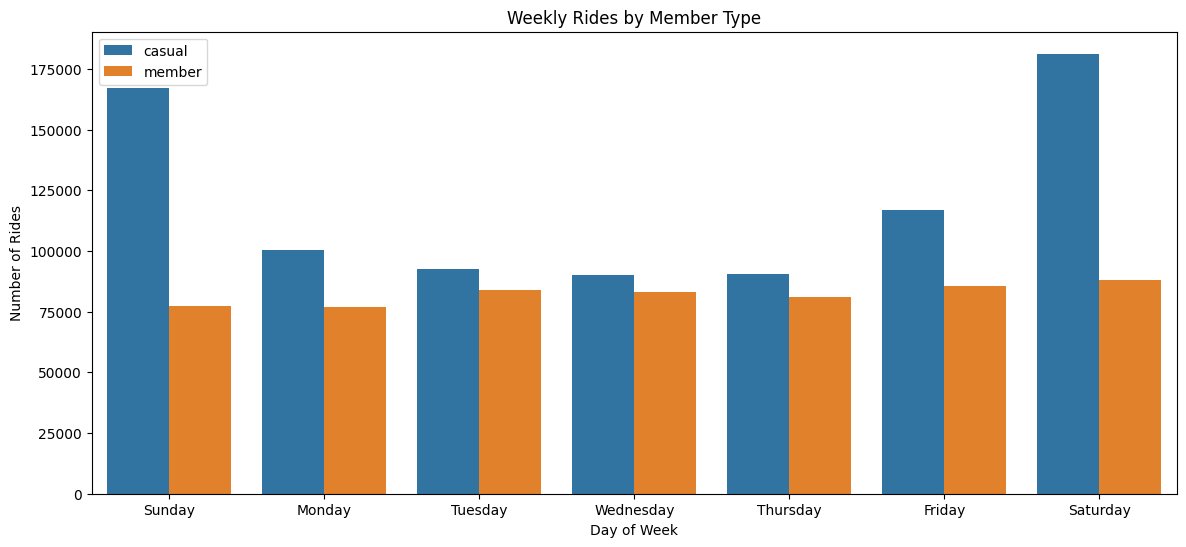

In [216]:
# What day of the week do outliers occcur more frequently
df_od = df.groupby(['member_casual','day']).count()['ride_id'].reset_index()

week_order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

# Plot
plt.figure(figsize = (14,6))
sns.barplot(data = df_od, x = 'day', y = 'ride_id', hue = 'member_casual', order= week_order)

plt.title('Weekly Rides by Member Type')
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')

# Show legend
plt.legend()

#### What time of the day do outliers occcur more frequently

  member_casual time_of_day  ride_id
0        casual   Afternoon   392747
1        casual     Morning   207186
2        casual       Night   238653
3        member   Afternoon   249464
4        member     Morning   164894
5        member       Night   161075


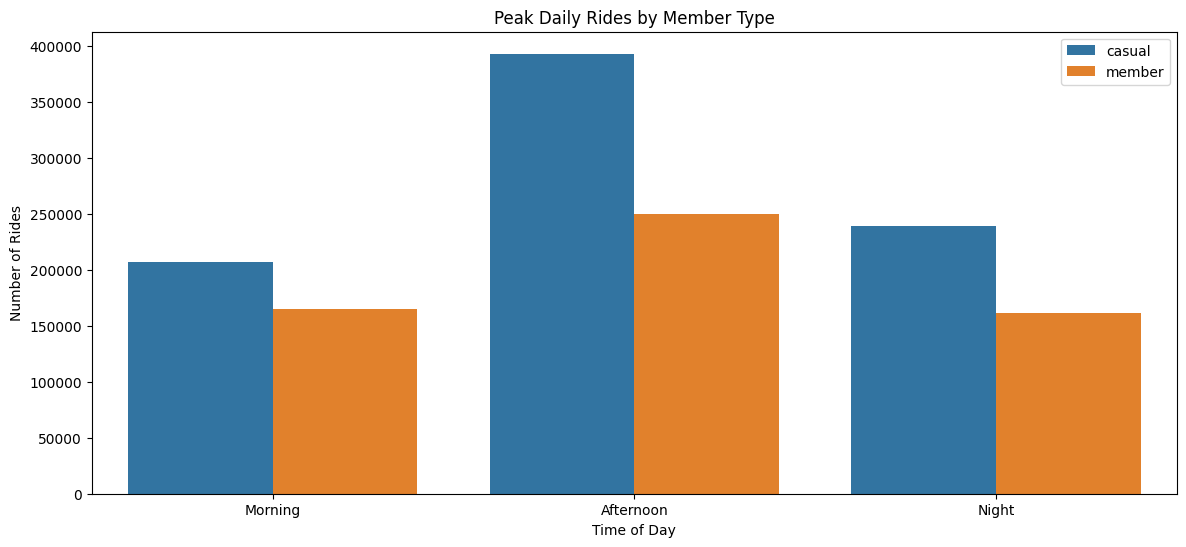

In [217]:
df_tod = df.groupby(['member_casual','time_of_day']).count()['ride_id'].reset_index()

day_order = ['Morning','Afternoon','Night']
# Plot
plt.figure(figsize = (14,6))
sns.barplot(data = df_tod, x = 'time_of_day', y = 'ride_id', hue = 'member_casual', order= day_order)

plt.title('Peak Daily Rides by Member Type')
plt.xlabel('Time of Day')
plt.ylabel('Number of Rides')

# Show legend
plt.legend()

print(df_tod)

#### Are there specific times or seasons when outliers are more common?

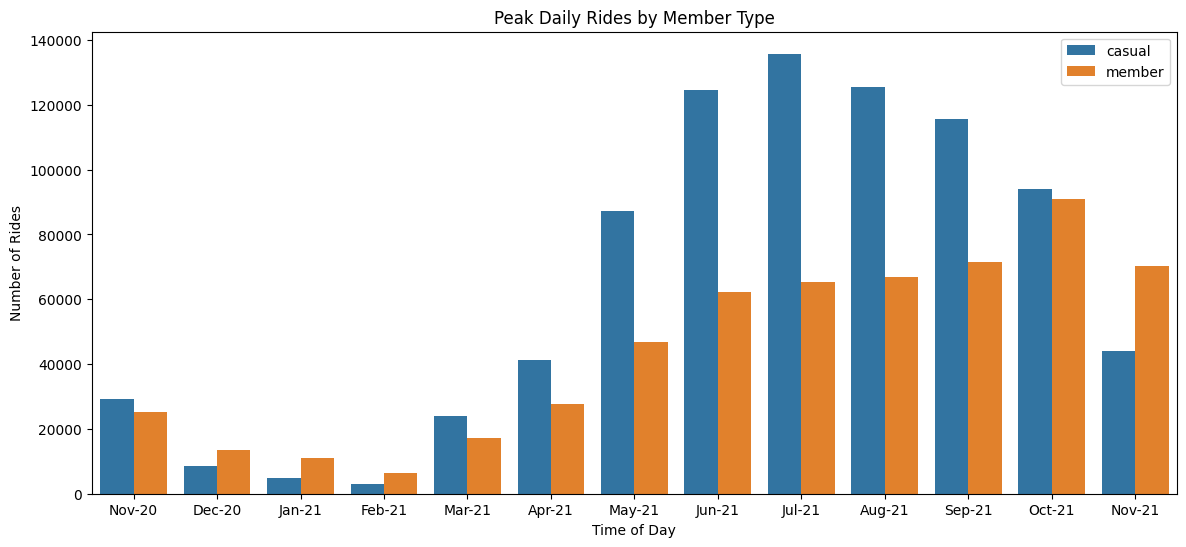

In [218]:
df_mod = df.groupby(['member_casual','month']).count()['ride_id'].reset_index()

month_order = ['Nov-20','Dec-20','Jan-21','Feb-21','Mar-21','Apr-21','May-21','Jun-21','Jul-21',
               'Aug-21','Sep-21','Oct-21','Nov-21']
# Plot
plt.figure(figsize = (14,6))
sns.barplot(data = df_mod, x = 'month', y = 'ride_id', hue = 'member_casual', order= month_order)


plt.title('Peak Daily Rides by Member Type')
plt.xlabel('Time of Day')
plt.ylabel('Number of Rides')

# Show legend
plt.legend()

## Station and Location Analysis
Which stations have the most missing data?

Outliers - Memeber Start Station

In [219]:
# Outlier Start stations and the location
print(f'The most used member station is: {df['start_station_name'].value_counts().reset_index()['start_station_name'][0]}')
print('The Top 10 member stations by ride count:')
df_m = df[df['member_casual'] == 'member'] 
df_m['start_station_name'].value_counts().sort_values(ascending=False).iloc[0:10]

The most used member station is: Streeter Dr & Grand Ave
The Top 10 member stations by ride count:


start_station_name
University Ave & 57th St      2116
Ellis Ave & 60th St           2013
Kimbark Ave & 53rd St         1607
Streeter Dr & Grand Ave       1506
Kedzie Ave & Milwaukee Ave    1482
Dearborn St & Erie St         1473
Ellis Ave & 55th St           1387
Shore Dr & 55th St            1313
Wabash Ave & Grand Ave        1261
Clark St & Elm St             1214
Name: count, dtype: int64

Outlier - Member Destination Station

In [220]:
print(f'The most used member station is: {df['end_station_name'].value_counts().reset_index()['end_station_name'][0]}')
print('The Top 10 member stations by ride count:')
df_md = df[df['member_casual'] == 'member'] 
df_md['end_station_name'].value_counts().sort_values(ascending=False).iloc[0:10]

The most used member station is: Streeter Dr & Grand Ave
The Top 10 member stations by ride count:


end_station_name
Ellis Ave & 60th St           1830
University Ave & 57th St      1777
Dearborn St & Erie St         1620
Streeter Dr & Grand Ave       1401
Kimbark Ave & 53rd St         1331
Wabash Ave & Grand Ave        1288
Clark St & Elm St             1283
Damen Ave & Pierce Ave        1241
Broadway & Barry Ave          1241
Kedzie Ave & Milwaukee Ave    1214
Name: count, dtype: int64

Oultiers - Casual Start Station

In [221]:
# Outlier Start stations and the location
print(f'The most used member station is: {df['start_station_name'].value_counts().reset_index()['start_station_name'][0]}')
print('The Top 10 casual stations by ride count:')
df_c = df[df['member_casual'] == 'casual'] 
df_c['start_station_name'].value_counts().sort_values(ascending=False).iloc[0:10]

The most used member station is: Streeter Dr & Grand Ave
The Top 10 casual stations by ride count:


start_station_name
Streeter Dr & Grand Ave              19418
Millennium Park                      12935
Michigan Ave & Oak St                 9644
Lake Shore Dr & Monroe St             7335
Shedd Aquarium                        5656
Indiana Ave & Roosevelt Rd            5126
Theater on the Lake                   5075
Michigan Ave & Washington St          4975
DuSable Lake Shore Dr & Monroe St     4775
Buckingham Fountain                   4768
Name: count, dtype: int64

In [222]:
print(f'The most used member station is: {df['end_station_name'].value_counts().reset_index()['end_station_name'][0]}')
print('The Top 10 member stations by ride count:')
df_md = df[df['member_casual'] == 'casual'] 
df_md['end_station_name'].value_counts().sort_values(ascending=False).iloc[0:10]

The most used member station is: Streeter Dr & Grand Ave
The Top 10 member stations by ride count:


end_station_name
Streeter Dr & Grand Ave              20972
Millennium Park                      11640
Michigan Ave & Oak St                10048
Lake Shore Dr & Monroe St             7117
Theater on the Lake                   5997
Shedd Aquarium                        4815
DuSable Lake Shore Dr & Monroe St     4803
Indiana Ave & Roosevelt Rd            4753
Michigan Ave & 8th St                 4459
Buckingham Fountain                   4442
Name: count, dtype: int64

## Summary and Conclusion
- Members Analysis: Outliers are characterized by significantly longer ride durations, especially for casual riders.
- Bike Type-Based Analysis: Electric bikes have a much higher rate of anomalies compared to classic and docked bikes. This might be due to more frequent technical issues associated with electric bikes.
- Weekends (Saturday and Sunday) show a higher incidence of anomalies for both casual riders and members, suggesting higher usage during peak days.
- Outliers are most frequent in the afternoon for both casual riders and members. This might be due to higher activity levels and potential system overloads during these times.
- Summer months (June, July, and August) and early fall (September and October) see a higher incidence of outliers for both casual riders and members. This pattern suggests seasonal peaks in usage which might lead to more data anomalies due to increased system load or seasonal events affecting ride behavior.